In [22]:
import numpy as np
import pickle
import tensorly as tf
from skfda.representation.basis import BSplineBasis
from scipy.linalg import solve_sylvester, sqrtm
from scipy.sparse.linalg import LinearOperator, gmres
from scipy.special import softmax
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.padder import PaddingTransformer
import pandas as pd
import warnings
import time

# tf.set_backend('cupy')
rng = np.random.default_rng()

# %matplotlib notebook

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cmap = plt.cm.Spectral(np.linspace(0, 1, 25))

In [2]:
def nearPSD(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
    D = np.clip(D, 0, np.inf)
    return Q @ np.diag(D) @ Q.T

In [3]:
def matSqrt(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
#     print(D)
    D = np.sqrt(np.clip(D, 0, np.inf))
#     print(D)
    return Q @ np.diag(D) @ Q.T

# Data Loading and Preprocessing

The data is in the form of two lists: $X$ and $y$, each of size `n_samples`. $y$ is simply a list of targets, where each element is the class that the corresponding element in $X$ belongs to. $X$ is a list of $(T_i+1)\times(F_i+1)$ matrices, where the first column stores the timepoints and the first row stores the features recorded for each sample. The other elements are feature values at the corresponding timepoints.

## Data Loading and Plotting

The data is loaded from the `data.pickle` file, and one sample from each class is plotted. Each plot represents one feature, and each colour represents one class.

# Model

The model is implemented as an instance of a scikit-learn `estimator` class. It implements interface functions `transform`, `fit_transform`, `predict`, `predict_proba` and `predict_log_proba` according to the specification, and can also be used in the beginning of a scikit-learn `Pipeline` in order to transform irregular tensor data into an `n_samples`$\times$`r` matrix, which can then be further processed using other scikit-learn estimators.

Assume that data is recorded at $T$ timepoints and for $F$ features. Let there be $K$ classes $i=1,2,\ldots,K$ and $j=1,2,\ldots,m_i$ subjects in each class. For each subject, let the timepoints recorded be $t_1, t_2,\ldots,t_{T_{ij}}$ and the features recorded be $f_1,f_2,\ldots,f_{F_{ij}}$. The model can be described as $$Y_{ij}=S_{ij}(\lambda_0 + \Lambda\alpha_i\xi + \gamma_{ij})C_{ij} + \epsilon_{ij}$$
Here $Y_{ij}\in\mathbb{R}^{T_{ij}\times F_{ij}}$ are the data matrices, where each row is a timepoint and each column is a feature. $S_{ij}$s are the spline matrices, formed from the spline basis function set $\{\mathbf{s}_1(t), \mathbf{s}_2(t),\ldots,\mathbf{s}_b(t)\}$. Similar to $Y_{ij}$, the rows are timepoints and the columns are basis functions, so the matrix is defined as $$S_{ij}=\begin{bmatrix}
\mathbf{s}_1(t_1) &\mathbf{s}_2(t_1) &\cdots &\mathbf{s}_b(t_1)\\
\mathbf{s}_1(t_2) &\mathbf{s}_2(t_2) &\cdots &\mathbf{s}_b(t_2)\\
&\vdots\\
\mathbf{s}_1(t_{T_{ij}}) &\mathbf{s}_2(t_{T_{ij}}) &\cdots &\mathbf{s}_b(t_{T_{ij}})\\
\end{bmatrix}$$ $C_{ij}\in\mathbb{R}^{F\times F_{ij}}$ are the $\{f_1^{th}, f_2^{th},\ldots,f_{F_{ij}}^{th}\}$ columns of an $F\times F$ identity matrix, $\lambda_0\in\mathbb{R}^{b\times F}$ is the mean parameter, $\alpha_i\in\mathbb{R}^{r\times r}$s are the reduced rank linear discriminants, $\Lambda\in\mathbb{R}^{b\times r}$ and $\xi\in\mathbb{R}^{r\times F}$ are matrices used to compute the full rank linear discriminants, $\gamma_{ij}\in\mathcal{N}_{b\times F}(0,\Sigma,\Psi)$ is the internal autoregressive noise and $\epsilon_{ij}\sim\mathcal{N}_{T_{ij}\times F_{ij}}(0,\sigma^2I)$ is the measurement noise.
We use an ECM algorithm to fit the model to the data, for computational efficiency.

In [17]:
class MFLDA(BaseEstimator, TransformerMixin, ClassifierMixin):
    
    def __init__(self, r=2, nBasis=4, SigmaRank = None, PsiRank = None, splineOrder = 3, regularizer=1e-7, n_iter=1000, criterion='bic'):
        
        # Initializing all hyperparameters
        
        self.nBasis = nBasis #Number of spline basis functions used
        self.r = r #Number of dimensions to reduce to
        self.SigmaRank = SigmaRank #Rank of Sigma, or time autocovariance(used to avoid local maximas)
        self.PsiRank = PsiRank #Rank of Psi, or feature autocovariance(used to avoid local maximas)
        self.splineOrder = splineOrder #Order of the spline, deafult is 3
        self.regularizer = regularizer #Regularization value used to compute inverses of non-invertible matrices
        self.n_iter = n_iter #Number of iterations to run for the ECM algorithm
        self.criterion = 'bic'
        super().__init__()
        
    def preprocess(self, X):

        t = []
        f = []
        x = []
        for i in range(len(X)):
            t.append(X[i][1:, 0])
            f.append(X[i][0, 1:])
            x.append(X[i][1:,1:])
#                 t.append(X[i][1:, 0].get())
#                 f.append(X[i][0, 1:].get())
#                 x.append(X[i][1:,1:].get())

        return t, f, x

    def Estep(self, x, y, S, C):

        #Takes one sample and performs the E-Step for that sample to compute the corresponding gamma'
        
        #Set up the Sylvester equation
        beta = self.lambda0_ + self.Lambda_ @ np.diag(self.alpha_[y]) @ self.xi_
        PsiPrime = C.T @ self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T @ C
        SigmaPrime = S @ self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T @ S.T
        centeredX = (x - S @ beta @ C) @ PsiPrime.T
        
        #Solve the Sylvester equation
        gamma = solve_sylvester(self.sigma2_ * np.linalg.pinv(SigmaPrime), PsiPrime.T, centeredX)
        gamma = np.array(gamma)

        return gamma
        
    
    # Compute the parameters lambda0, Lambda, alpha, xi
    def MStepLinear(self, x, y, m, gammaPrime, S, C):
        
        #Define LHS of first equation as a function instead of a matrix multiply. This allows us to use GMRES
        #and solve the matrix equation without a large matrix inversion
        def mv(v, target):
            
            v = v.reshape(self.n_features, self.nBasis).T
            s = np.zeros((self.nBasis, self.n_features))
            impIdxs = np.where(y == target)[0] #Choose samples belonging to the current class
            for i in impIdxs:
                s += S[i].T @ S[i] @ v @ C[i] @ C[i].T #Multiply and add the corresponding S and C matrices
            s = s.T.flatten()
            return s
        
        #Convert the above function into a linear operator and solve using GMRES
        A = [LinearOperator((self.nBasis * self.n_features, self.nBasis * self.n_features), matvec=lambda x: mv(x, i)) for i in range(self.n_classes)]
        b = np.zeros((self.n_classes, self.nBasis, self.n_features))
        for i in range(len(x)):
            centeredX = x[i] - gammaPrime[i]
            b[y[i]] += S[i].T @ centeredX @ C[i].T
        beta = [gmres(A[i], b[i].T.flatten())[0].reshape(self.n_features, self.nBasis).T for i in range(self.n_classes)]
        lambda0 = np.average(beta, axis=0, weights=m) #Compute lambda0 by weighted average
        beta -= lambda0 #De-mean beta by subtracting lambda0
        
        #Compute the other linear params by a PARAFAC decompositon, similar to SVD
        weights, loadings = tf.decomposition.parafac(beta, self.r, normalize_factors=True)
        weights = np.diag(weights)
        alpha = np.zeros((self.n_classes, self.r))
        for i in range(self.n_classes):
            alpha[i] = weights @ loadings[0][i] #Convert the PARAFAC kernel to an alpha for each class
        Lambda = loadings[1]
        xi = loadings[2]
        
        
        return lambda0, Lambda, alpha, xi.T
    
    #Compute parameters Sigma, Psi. sigma2
    def MStepVar(self, x, y, gammaPrime, S, C, sigma2, lambda0, Lambda, alpha, xi):
        
        #Initialize some values in order to start iterations
        prevSigma2 = 1
        Sigma = np.eye(self.SigmaRank)
        Psi = np.eye(self.PsiRank)
        gamma = np.zeros((len(gammaPrime), self.nBasis, self.n_features))
        t = 0
        f = 0
        den = 0
        
        #Compute gammas to be used for computing Sigma and Psi
        for i in range(len(gammaPrime)):
            tmp = np.linalg.lstsq(C[i].T, gammaPrime[i].T, rcond=None)[0].T
            gamma[i] = np.linalg.lstsq(S[i], tmp, rcond=None)[0]
            t += x[i].shape[0]
            f += x[i].shape[1]
            den += x[i].flatten().shape[0]
        max_iter = 50
        currIter = 0
        
        #Run iterations until max_iter is reached, or convergence is achieved
        while ((np.abs(prevSigma2 - sigma2) / prevSigma2) > 1e-5) and (currIter < max_iter):
            prevSigma2 = sigma2 #Store current value of sigma2 to check for convergence
            
            # Estimate the autocovariance parameters
            SigmaNew = np.zeros((self.nBasis, self.nBasis))
            PsiNew = np.zeros((self.n_features, self.n_features))
            for i in range(len(x)):
#                 SigmaNew += gamma[i] @ np.linalg.lstsq(Psi + self.regularizer * np.eye(self.n_features), gamma[i].T)[0]
                SigmaNew += gamma[i] @ np.linalg.lstsq(Psi, gamma[i].T, rcond=1)[0]
            Sigma = nearPSD(SigmaNew / f)
#             Sigma = nearPSD(Sigma) / Sigma[0,0]
            
            for i in range(len(x)):
#                 PsiNew += gamma[i].T @ np.linalg.lstsq(Sigma + self.regularizer * np.eye(self.nBasis), gamma[i])[0]
                PsiNew += gamma[i].T @ np.linalg.lstsq(Sigma, gamma[i], rcond=1)[0]
            Psi = nearPSD(PsiNew / t)
#             Psi = nearPSD(Psi) / Psi[0,0]
            
#             num = 0
#             for i in range(len(X)):
#                 num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])
#             scale = num / den
#             Sigma *= np.sqrt(scale)
#             Psi *= np.sqrt(scale)
            
            #Compute sigma2
            num = 0
            for i in range(len(x)):
                num += np.linalg.norm(x[i] - S[i] @ (lambda0 + Lambda @ np.diag(alpha[y[i]]) @ xi) @ C[i] - gammaPrime[i]) + np.trace(C[i].T @ Psi @ C[i]) * np.trace(S[i] @ Sigma @ S[i].T)
#                 den += x[i].shape[0] * x[i].shape[1]
            sigma2 = np.clip(num / den, 1e-5, 1e5) #Ensure sigma2 is not too small or too big
            currIter += 1
        #Perform eigendecompositons in order to obtain reduced rank estimated via an Eckart-Young type theorem
#         print(scale)
#         print(DSigma, DPsi)
        
        return Sigma, Psi, sigma2        
    
    def fit(self, X, y):
                
        t, f, x = self.preprocess(X)
        
        #Initialize all parameters
        self.features_ = np.unique(np.concatenate(f))
        self.n_features = len(self.features_)
        self.tPoints = np.unique(np.concatenate(t))
        if self.SigmaRank == None:
            self.SigmaRank = self.nBasis
        if self.PsiRank == None:
            self.PsiRank = self.n_features
        self.splineDomain = (np.min(self.tPoints), np.max(self.tPoints))
        
        #Compute the spline basis functions
        self.basis = BSplineBasis(
            domain_range = self.splineDomain,
            n_basis = self.nBasis,
            order = self.splineOrder
        )
        
        #Compute spline and feature selection matrices S and C respectively
        self.CFull = np.eye(self.n_features)
        S = np.zeros(len(X)).tolist()
        C = np.zeros(len(X)).tolist()
        for i in range(len(f)):
            idx = np.array([]).astype('int')
            for j in f[i]:
                idx = np.append(idx, np.where(self.features_ == j))
            idx.sort()
            f[i] = idx.astype('int')
            S[i] = np.array(self.basis(t[i]).squeeze().T)
            C[i] = self.CFull[:,np.atleast_1d(f[i])]
        
        self.classes_, y, m = np.unique(y, return_inverse=True, return_counts=True)
        self.n_classes = len(self.classes_)
        self.lambda0_ = rng.random((self.nBasis, self.n_features))
        self.Lambda_ = rng.random((self.nBasis, self.r))
        self.alpha_ = rng.random((self.n_classes, self.r))
        self.xi_ = rng.random((self.r, self.n_features))
        self.sigma2_ = rng.random()
        self.thetaSigma_ = rng.random((self.nBasis, self.SigmaRank))
        self.thetaPsi_ = rng.random((self.n_features, self.PsiRank))
        self.DSigma_ = rng.random(self.SigmaRank)
        self.DPsi_ = rng.random(self.PsiRank)
        score = self.logLikelihood(t, f, x, y, self.lambda0_, self.Lambda_, self.alpha_, self.xi_, self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T, self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T, self.sigma2_) #Add a stopping criterion
        
        #Run the ECM algorithm for n_iter steps
        for iteration in range(self.n_iter):
            prevScore = score
            gammaPrime = []
            
            #E-Step
            #TODO: If possible parallelize to run for all samples at the same time
            for i in range(len(x)):
                gammaPrime.append(self.Estep(x[i], y[i], S[i], C[i]))

            #CM-Steps
            lambda0, Lambda, alpha, xi = self.MStepLinear(x, y, m, gammaPrime, S, C)
#             self.thetaSigma_, self.DSigma_, self.thetaPsi_, self.DPsi_, self.sigma2_ = self.MStepVar(x, y, gammaPrime, S, C, self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T, self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T, self.sigma2_)
            
            Sigma, Psi, sigma2 = self.MStepVar(x, y, gammaPrime, S, C, self.sigma2_, lambda0, Lambda, alpha, xi)
            
            #Compute the stopping criterion and stop if criterion is fulfilled
#             if score > prevScore and iteration >= 5:
#                 print(iteration)
#                 break
            
#             print(score)
            score = self.logLikelihood(t, f, x, y, lambda0, Lambda, alpha, xi, Sigma, Psi, sigma2)
            if score > prevScore and iteration > 1:
                break
        
            try:
                DSigma, thetaSigma = np.linalg.eigh(Sigma)
                DPsi, thetaPsi = np.linalg.eigh(Psi)
            except np.linalg.LinAlgError:
                print(Sigma, '\n', Psi)
                raise ValueError
            self.thetaSigma_ = thetaSigma[:,-self.SigmaRank:]
            self.thetaPsi_ = thetaPsi[:,-self.PsiRank:]
    #         print(DSigma, DPsi)
            self.DSigma_ = DSigma[-self.SigmaRank:]
            self.DPsi_ = DPsi[-self.PsiRank:]
            self.lambda0_ = lambda0
            self.Lambda_ = Lambda
            self.alpha_ = alpha
            self.xi_ = xi
            self.sigma2_ = sigma2
        
        return self
    
    #Stopping criterion
    def logLikelihood(self, t, f, x, y, lambda0, Lambda, alpha, xi, Sigma, Psi, sigma2):
        r = 0
        for i in range(len(x)):
            S = self.basis(t[i]).squeeze().T
            C = self.CFull[:,f[i].astype('int')]
            SigmaPrime = S @ Sigma @ S.T
            PsiPrime = C.T @ Psi @ C
            currX = (x[i] - S @ (lambda0 + Lambda @ np.diag(alpha[y[i]]) @ xi) @ C).T.flatten()
            var = sigma2 * np.eye(t[i].shape[0] * f[i].shape[0]) + np.kron(PsiPrime, SigmaPrime)
            r += currX @ np.linalg.lstsq(var, currX, rcond=None)[0] + np.linalg.slogdet(var)[1]
        return r/2
    
    #Compute a low-dimensional representation of new data
    def transform(self, X):
        
        t, f, x = self.preprocess(X)
        Y = np.zeros((len(X), self.r * self.r)) #target low dimension matrix
        
        #Compute the variance parameters
        Sigma = self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T
        Psi = self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T
        
        for i in range(len(X)):
            #Compute S and C matrices
            S = self.basis(t[i]).squeeze().T
            idx = np.array([])
            for j in f[i]:
                idx = np.append(idx, np.where(self.features_ == j)).astype('int')
            idx.sort()
            C = self.CFull[:,np.atleast_1d(idx)]
            
            #Compute variances for the current sample
            SigmaPrime = np.atleast_2d(S @ Sigma @ S.T)
            PsiPrime = np.atleast_2d(C.T @ Psi @ C)
            
            #Compute \hat{alpha}_Y
            centeredX = x[i] - S @ self.lambda0_ @ C
#             print(S @ self.lambda0_ @ C)
            centeredX = np.linalg.lstsq(PsiPrime, centeredX.T, rcond=None)[0].T
            centeredX = solve_sylvester(SigmaPrime, self.sigma2_ * np.linalg.pinv(PsiPrime).T, centeredX)
            centeredX = self.Lambda_.T @ S.T @ centeredX @ C.T @ self.xi_.T
            M = self.sigma2_ * np.eye(t[i].shape[0] * f[i].shape[0]) + np.kron(PsiPrime, SigmaPrime)
            A = np.kron(C.T @ self.xi_.T, S @ self.Lambda_)
            var = A.T @ np.linalg.lstsq(M, A, rcond=None)[0]
            alpha = np.linalg.lstsq(matSqrt(var), centeredX.T.flatten(), rcond=None)[0]
            Y[i] = alpha
#             Y[i] = np.diag(alpha.reshape(self.r, self.r).T) #Add it to Y
            
        return Y
    
    def fit_transform(self, X, y):
        
        #Fit on new data and then transform
        self.fit(X, y)
        return self.transform(X)
    
    def predict_log_proba(self, X):
        
        #Compute partial log likelihood for new data
        
        t, f, x = self.preprocess(X)
        predProbs = np.zeros((len(X), self.n_classes))
        Sigma = self.thetaSigma_ @ np.diag(self.DSigma_) @ self.thetaSigma_.T
        Psi = self.thetaPsi_ @ np.diag(self.DPsi_) @ self.thetaPsi_.T
        
        for i in range(len(X)):
            
            #Compute S and C matrices
            S = self.basis(t[i]).squeeze().T
            idx = []
            for j in f[i]:
                idx = np.append(idx, np.where(self.features_ == j)).astype('int')
            idx.sort()
            C = self.CFull[:,np.atleast_1d(idx)]
            
            #Compute the variances for each sample
            SigmaPrime = np.atleast_2d(S @ Sigma @ S.T)
            PsiPrime = np.atleast_2d(C.T @ Psi @ C)
            centeredX = x[i] - S @ self.lambda0_ @ C
            centeredX = np.linalg.lstsq(PsiPrime, centeredX.T, rcond=None)[0].T
            centeredX = solve_sylvester(SigmaPrime, self.sigma2_ * np.linalg.pinv(PsiPrime).T, centeredX)
            centeredX = self.Lambda_.T @ S.T @ centeredX @ C.T @ self.xi_.T
            M = self.sigma2_ * np.eye(t[i].shape[0] * f[i].shape[0]) + np.kron(PsiPrime, SigmaPrime)
            A = np.kron(C.T @ self.xi_.T, S @ self.Lambda_)
            var = sqrtm(A.T @ np.linalg.lstsq(M, A, rcond=None)[0])
            #Compute \hat{\alpha}_Y
            alpha = np.linalg.lstsq(var, centeredX.T.flatten(), rcond=None)[0].reshape(self.r, self.r).T
            
            for j in range(self.n_classes):
                #Compute corresponding alpha_i values and find distance
                target = (var @ np.diag(self.alpha_[j]).T.flatten()).reshape(self.r, self.r).T
                predProbs[i, j] = -np.linalg.norm(alpha - target)
        
        return predProbs
    
    def predict_proba(self, X):
        
        #Compute the actual class likelihoods
        #This is done be getting the partial log-likelihoods and applying a softmax to normalize
        
        logProbs = self.predict_log_proba(X)
        return softmax(logProbs, axis=1)
    
    def predict(self, X):
        
        NegLogProbs = -self.predict_log_proba(X) #Get partial log likelihoods
        classIdx = np.argmin(NegLogProbs, axis=1) #Choose class with maximum log likelihood
        return self.classes_[classIdx]
    
    def ic(self, X, y):
        
        if self.criterion != 'bic':
            raise NotImplementedError
        
        t, f, x = self.preprocess(X)
        for i in range(len(y)):
            y[i] = np.where(y[i] == self.classes_)[0][0]
        l = self.logLikelihood(t, f, x, y)
        numLinearParams = self.nBasis * self.r + self.r * self.n_classes + self.r * self.n_features
        numVarParams = (self.nBasis + 1) * self.SigmaRank + (self.n_features + 1) * self.PsiRank + 1
        return ((numLinearParams + numVarParams) * len(y) + 2 * l)

## Missing Data

In [13]:
X, y = pickle.load(open("trainWordRecognitionMissing.pickle", 'rb'))
X_test, y_test = pickle.load(open("testWordRecognitionReducedMissing.pickle", 'rb'))

<IPython.core.display.Javascript object>


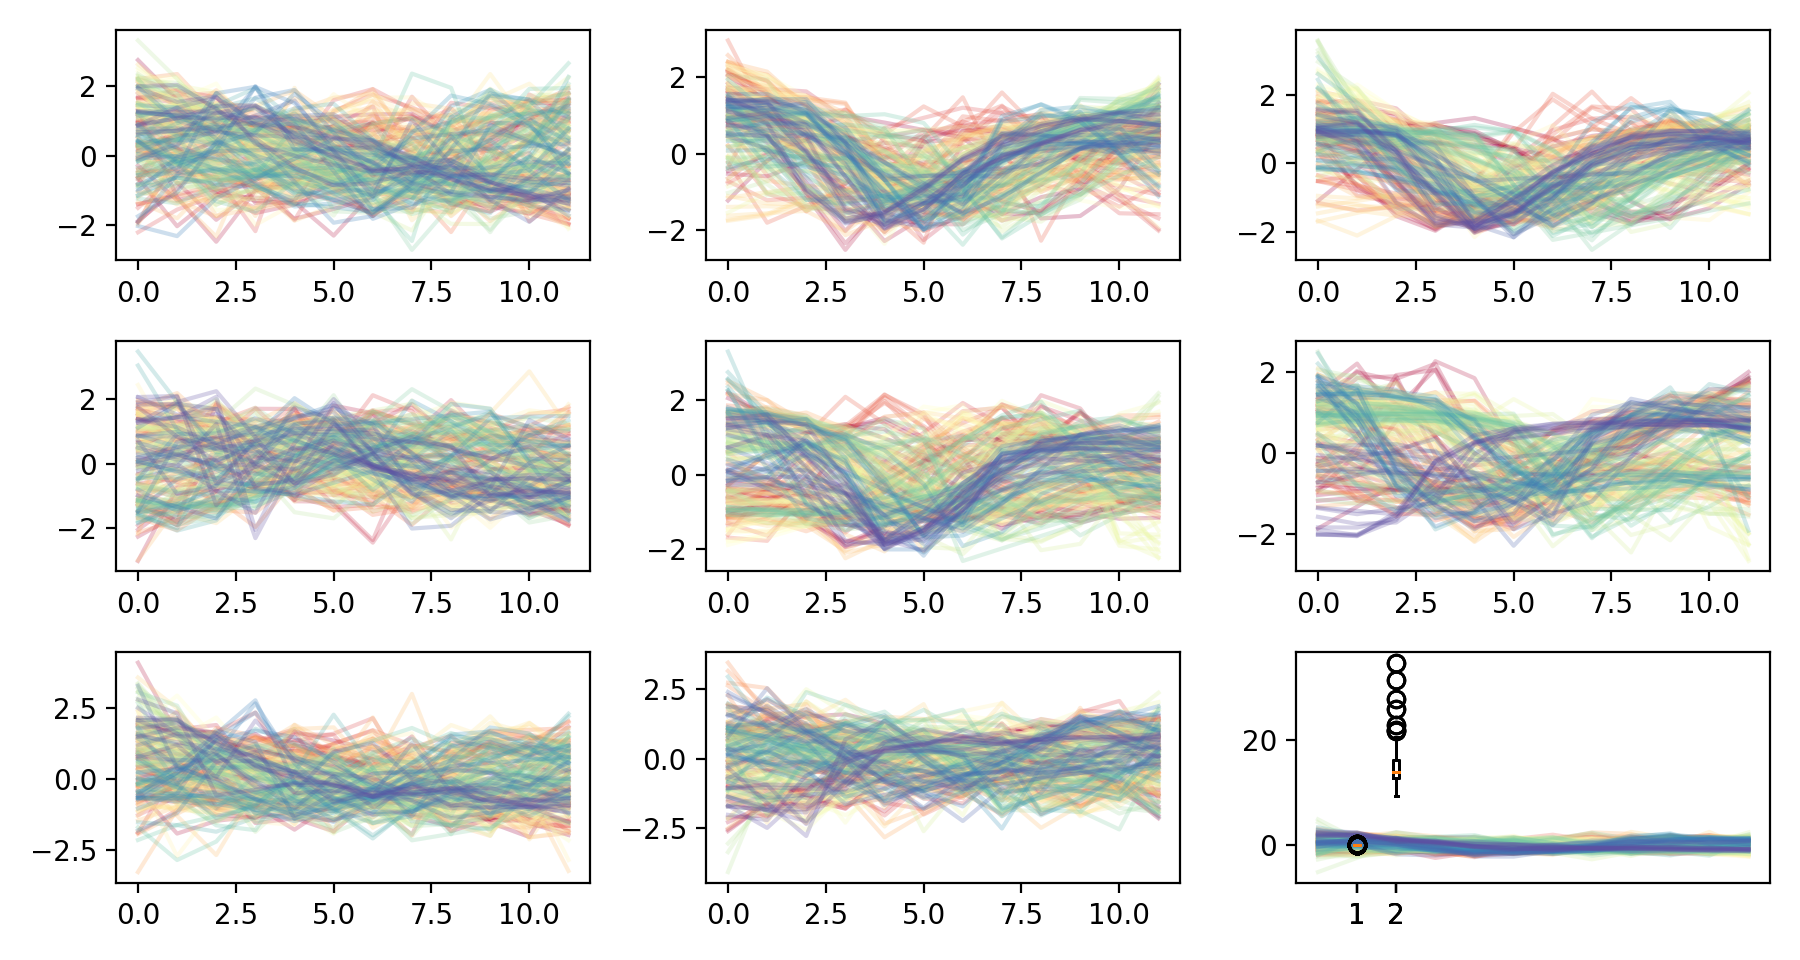

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(len(X)):
    featIdx = X[i][0,1:].astype('int')
    for col, j in enumerate(featIdx):
        ax[j//3, j%3].plot(X[i][1:,0], X[i][1:,col+1], color=cmap[y[i] - 1], alpha=0.25)
fig.tight_layout()

In [327]:
model = MFLDA(r=9, n_iter=300, nBasis=9).fit(X, y)

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3335280538.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


1.5763707774528926
61597.58010947112
1.2473301385055202
13442.333806467186


In [328]:
x = model.transform(X)
classifier = RidgeClassifierCV().fit(x, y)
x = model.transform(X_test)
print(classification_report(y_test, classifier.predict(x)))

              precision    recall  f1-score   support

           1       0.83      0.42      0.56        12
           2       0.82      0.75      0.78        12
           3       0.90      0.75      0.82        12
           4       0.77      0.83      0.80        12
           5       0.85      0.92      0.88        12
           6       0.89      0.67      0.76        12
           7       0.79      0.92      0.85        12
           8       1.00      0.83      0.91        12
           9       0.89      0.67      0.76        12
          10       0.71      1.00      0.83        12
          11       0.69      0.92      0.79        12
          12       0.73      0.67      0.70        12
          13       0.62      0.83      0.71        12
          14       0.64      0.75      0.69        12
          15       0.67      1.00      0.80        12
          16       0.50      0.33      0.40        12
          17       1.00      0.83      0.91        12
          18       0.36    

### Padding Type-1

In [315]:
paddedX = []
for i in range(len(X)):
    currX = X[i]
    newX = currX[0,:]
    prevTPoint = -1
    for idx, tPoint in enumerate(currX[1:,0]):
        if tPoint - prevTPoint > 1:
            for j in range((tPoint - prevTPoint - 1).astype('int')):
                newX = np.vstack((newX, np.zeros(currX.shape[1])))
        newX = np.vstack((newX, currX[idx+1,:]))
    #             print(idx, tPoint, currX[idx+1,:])
        prevTPoint = tPoint
    if prevTPoint < 11.:
        for j in range((11 - prevTPoint).astype('int')):
            newX = np.vstack((newX, np.zeros(currX.shape[1])))
    newX[1:,0] = np.arange(12)
    # print(newX)
    currX = newX
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX.append(newX)

In [316]:
paddedX_test = []
for i in range(len(X_test)):
    currX = X_test[i]
    newX = currX[0,:]
    prevTPoint = -1
    for idx, tPoint in enumerate(currX[1:,0]):
        if tPoint - prevTPoint > 1:
            for j in range((tPoint - prevTPoint - 1).astype('int')):
                newX = np.vstack((newX, np.zeros(currX.shape[1])))
        newX = np.vstack((newX, currX[idx+1,:]))
    #             print(idx, tPoint, currX[idx+1,:])
        prevTPoint = tPoint
    if prevTPoint < 11.:
        for j in range((11 - prevTPoint).astype('int')):
            newX = np.vstack((newX, np.zeros(currX.shape[1])))
    newX[1:,0] = np.arange(12)
    # print(newX)
    currX = newX
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX_test.append(newX)

In [317]:
rocketPipeline = make_pipeline(Rocket(num_kernels=41), RidgeClassifierCV())
x = pd.DataFrame([[pd.Series(paddedX[j][1:,i]) for i in range(1, 10)] for j in range(275)])
rocketPipeline.fit(x, y)
x = pd.DataFrame([[pd.Series(paddedX_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
print(classification_report(y_test, rocketPipeline.predict(x)))

              precision    recall  f1-score   support

           1       0.45      0.42      0.43        12
           2       0.67      1.00      0.80        12
           3       0.60      0.75      0.67        12
           4       0.55      0.50      0.52        12
           5       0.50      0.58      0.54        12
           6       0.50      0.42      0.45        12
           7       0.67      0.67      0.67        12
           8       0.67      0.33      0.44        12
           9       0.55      0.50      0.52        12
          10       0.50      0.58      0.54        12
          11       0.79      0.92      0.85        12
          12       0.30      0.25      0.27        12
          13       0.50      0.67      0.57        12
          14       0.82      0.75      0.78        12
          15       0.62      0.42      0.50        12
          16       0.22      0.17      0.19        12
          17       0.57      0.67      0.62        12
          18       0.40    

### Padding Type-2

In [318]:
paddedX = []
for i in range(len(X)):
    currX  = X[i]
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX.append(newX)

In [319]:
paddedX_test = []
for i in range(len(X_test)):
    currX  = X_test[i]
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX_test.append(newX)

In [331]:
rocketPipeline = make_pipeline(PaddingTransformer(), Rocket(num_kernels=41), RidgeClassifierCV())
x = pd.DataFrame([[pd.Series(paddedX[j][1:,i]) for i in range(1, 10)] for j in range(275)])
rocketPipeline = rocketPipeline.fit(x, y)
x = pd.DataFrame([[pd.Series(paddedX_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
print(classification_report(y_test, rocketPipeline.predict(x)))

              precision    recall  f1-score   support

           1       0.56      0.42      0.48        12
           2       0.50      0.50      0.50        12
           3       0.47      0.67      0.55        12
           4       0.44      0.33      0.38        12
           5       0.37      0.58      0.45        12
           6       0.56      0.42      0.48        12
           7       0.80      0.67      0.73        12
           8       0.42      0.42      0.42        12
           9       0.56      0.42      0.48        12
          10       0.44      0.58      0.50        12
          11       0.60      0.75      0.67        12
          12       0.38      0.42      0.40        12
          13       0.54      0.58      0.56        12
          14       0.50      0.50      0.50        12
          15       0.25      0.17      0.20        12
          16       0.33      0.08      0.13        12
          17       0.69      0.75      0.72        12
          18       0.44    

## No missing data

In [15]:
X, y = pickle.load(open("trainWordRecognition.pickle", 'rb'))
X_test, y_test = pickle.load(open("testWordRecognitionReduced.pickle", 'rb'))
# for i in range(len(X)):
#     X[i] = X[i][::12]

In [95]:
accTable = np.zeros((8, 2))
for r in range(2, 10):
    rocketAccuracy = 0
    modelPipeline = make_pipeline(MFLDA(r=r, n_iter=500, nBasis=9), RidgeClassifierCV())
    rocketPipeline = make_pipeline(Rocket(num_kernels=(r**2 + 1)//2), RidgeClassifierCV())
    for _ in range(10):
        x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
        rocketPipeline.fit(x, y)
        x = pd.DataFrame([[pd.Series(X_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
        rocketAccuracy += classification_report(y_test, rocketPipeline.predict(x), output_dict=True)['weighted avg']['f1-score']
    rocketAccuracy /= 10
    modelPipeline.fit(X, y)
    modelAccuracy = classification_report(y_test, modelPipeline.predict(X_test), output_dict=True)['weighted avg']['f1-score']
    accTable[r - 2,:] = [modelAccuracy, rocketAccuracy]
pd.DataFrame(accTable, index=range(2, 10), columns=['Model Accuracy', 'Rocket Accuracy']).to_csv('rocket_vs_mflda2.csv')

/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/d

/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


7.862262576090013
34312.120082762485
15.504291036759254
42423.17081914439


/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/d

/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


55.747382051244195
51398.00226255939
80.70225199368036
55756.28419757988


/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rahul/venvs/d

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


41.17147574132758
59105.65590351611
29.10650850716703
54034.88568451918
6.595796738453183
32902.51016765334
0.05106496642260935
37111.755956881105


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


95.63624558640751
62703.08082459961
117.08453095717437
65503.325261808845


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


645.4417687813298
83191.37729788772
201.26381153565376
64760.20935327923
70.02509480026859
49170.209948635274
0.42834072715565547
14067.062749694285
0.2638417719103541
21986.00915428215


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


31.364194342707314
49250.21538242932
54.11471392405258
56033.53186770214


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


70.99266113181118
69518.45228956002
67.87469165529303
68478.55361819101
5.104543288684425
31103.877384927397
273.08178841747605
122563.40464753512


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_64228/3016828500.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  num += np.trace(np.linalg.lstsq(Psi, gamma[i].T)[0] @ np.linalg.lstsq(Sigma, gamma[i])[0])


13.43041802602082
59786.364335551414
22.957230472013304
69562.2797529893


In [30]:
times = np.zeros((100, 2))
modelPipeline = make_pipeline(MFLDA(r=7, n_iter=500, nBasis=9), RidgeClassifierCV())
rocketPipeline = make_pipeline(Rocket(num_kernels=(7**2 + 1)//2), RidgeClassifierCV())
for k in tqdm(range(100)):
    
    x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
    start = time.time()
    rocketPipeline.fit(x, y)
    end = time.time()
    times[k, 0] = end - start
    start = time.time()
    modelPipeline.fit(X, y)
    end = time.time()
    times[k, 1] = end - start

# accTable[r - 2,:] = [pureModelAccuracy, modelAccuracy, rocketAccuracy, pureModelAccuracy, modelAccuracyMissing, rocketAccuracyMissing1, rocketAccuracyMissing2]

  0%|          | 0/100 [00:00<?, ?it/s]

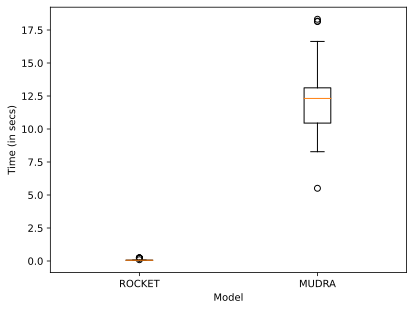

In [34]:
plt.xlabel('Model')
plt.ylabel('Time (in secs)')
plt.boxplot(times)
plt.xticks(np.arange(1, 3), ['ROCKET', 'MUDRA'])
plt.savefig('time.svg')

In [37]:
pd.DataFrame(times, columns=['ROCKET', 'MUDRA']).to_csv('times.csv')

In [96]:
pd.read_csv('rocket_vs_mflda2.csv', index_col=0)

Model Accuracy  Rocket Accuracy
2        0.299122         0.136040
3        0.703236         0.427894
4        0.852772         0.608913
5        0.903716         0.778197
6        0.886883         0.839906
7        0.934927         0.885403
8        0.939827         0.915214
9        0.949839         0.931336

In [96]:
pd.read_csv('rocket_vs_mflda2.csv', index_col=0)

Model Accuracy  Rocket Accuracy
2        0.299122         0.136040
3        0.703236         0.427894
4        0.852772         0.608913
5        0.903716         0.778197
6        0.886883         0.839906
7        0.934927         0.885403
8        0.939827         0.915214
9        0.949839         0.931336

In [20]:
modelPipeline = make_pipeline(MFLDA(r=9, n_iter=5, nBasis=9), RidgeClassifierCV())

In [21]:
modelPipeline.fit(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Pipeline(steps=[('mflda',
                 MFLDA(PsiRank=9, SigmaRank=9, nBasis=9, n_iter=5, r=9)),
                ('ridgeclassifiercv', RidgeClassifierCV())])

In [25]:
print(classification_report(y_test, modelPipeline.predict(X_test)))

  0%|          | 0/300 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.67      0.83      0.74        12
           2       1.00      1.00      1.00        12
           3       0.86      1.00      0.92        12
           4       1.00      0.92      0.96        12
           5       0.86      1.00      0.92        12
           6       1.00      1.00      1.00        12
           7       1.00      0.83      0.91        12
           8       0.79      0.92      0.85        12
           9       1.00      0.83      0.91        12
          10       0.77      0.83      0.80        12
          11       1.00      1.00      1.00        12
          12       0.89      0.67      0.76        12
          13       0.92      0.92      0.92        12
          14       0.79      0.92      0.85        12
          15       1.00      0.92      0.96        12
          16       1.00      0.33      0.50        12
          17       0.92      1.00      0.96        12
          18       0.77    

In [13]:
model = MFLDA(r=9, n_iter=500, nBasis=10).fit(X, y)

In [14]:
pts = model.transform(X)
classifier = RidgeClassifierCV().fit(pts, y)
pts = model.transform(X_test)
print(classification_report(y_test, classifier.predict(pts)))

AttributeError: 'MFLDA' object has no attribute 'thetaSigma_'

In [41]:
r = 0
for _ in tqdm(range(100)):
    x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
    rocket = Rocket(num_kernels=50).fit(x)
    x = rocket.transform(x)
    classifier = RidgeClassifierCV().fit(x, y)
    x = pd.DataFrame([[pd.Series(X_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
    x = rocket.transform(x)
    y_pred = classifier.predict(x)
    report = classification_report(y_test, y_pred, output_dict=True)
    r += report['weighted avg']['f1-score']
r /= 100
print(r)

  0%|          | 0/100 [00:00<?, ?it/s]

0.9464687053212794


<IPython.core.display.Javascript object>


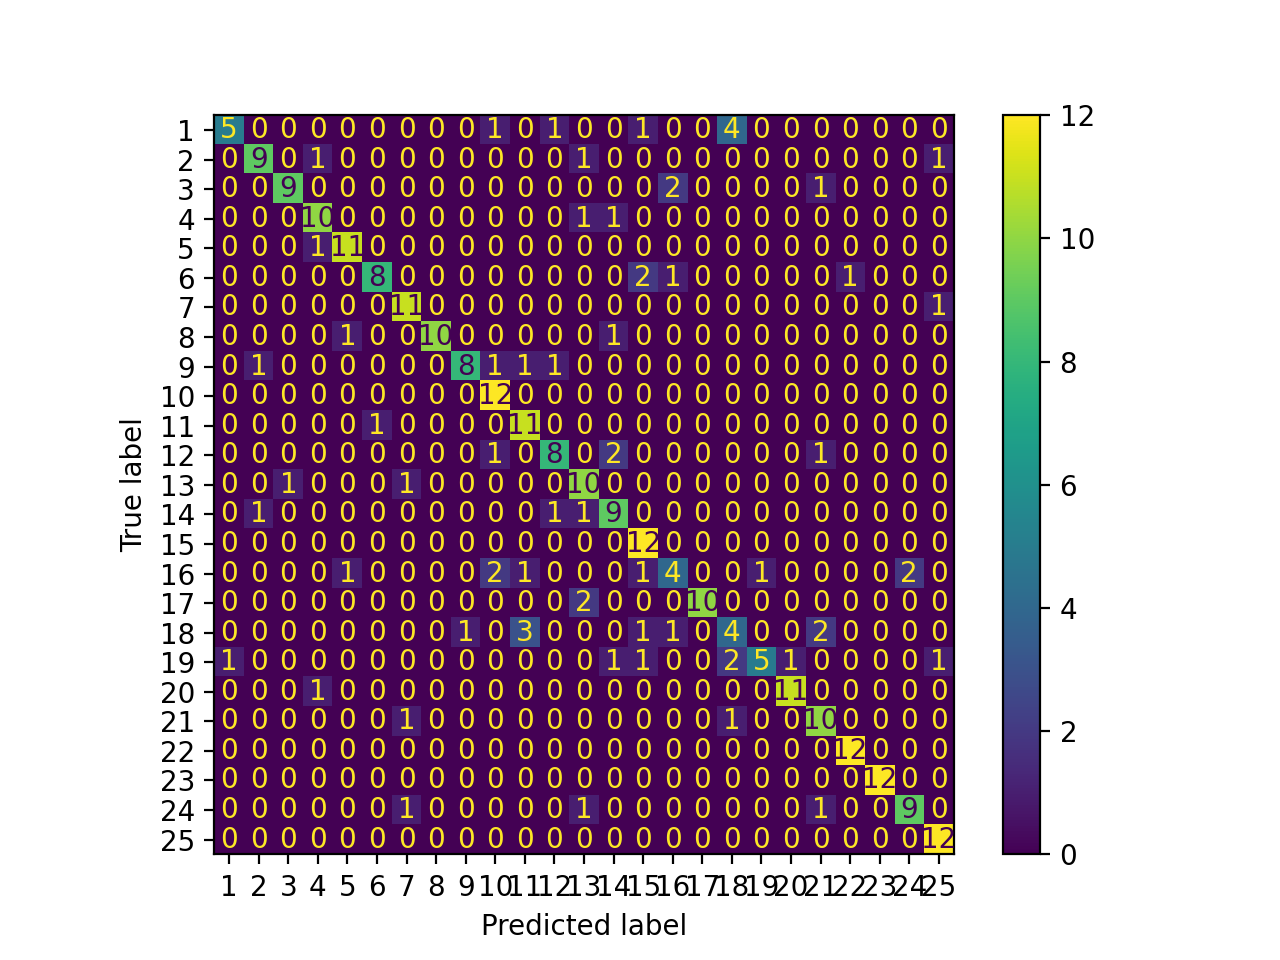

In [329]:
ConfusionMatrixDisplay.from_predictions(y_test, classifier.predict(model.transform(X_test)))

# Results

## r=2

### Fitting the data

We run the model with the given input data

In [54]:
model = MFLDA(r=2, n_iter=500, nBasis=6).fit(X, y)
pts = model.transform(X)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_109187/2406266435.py:115: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  SigmaNew += gamma[i] @ np.linalg.lstsq(Psi, gamma[i].T)[0]
/tmp/ipykernel_109187/2406266435.py:120: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  PsiNew += gamma[i].T @ np.linalg.lstsq(Sigma, gamma[i])[0]


  0%|          | 0/275 [00:00<?, ?it/s]

### Plot the estimated class functionals

We plot the estimated functionals. Each plot represents one feature, and each colour represents one class.

Let $S$ be the spline basis matrix evaluated at all time points for which any data was recorded. Then the class functionals can simply be estimated as $$Y=S(\lambda_0 + \Lambda\alpha_i\xi)$$, where each column represents one feature functional.

<IPython.core.display.Javascript object>


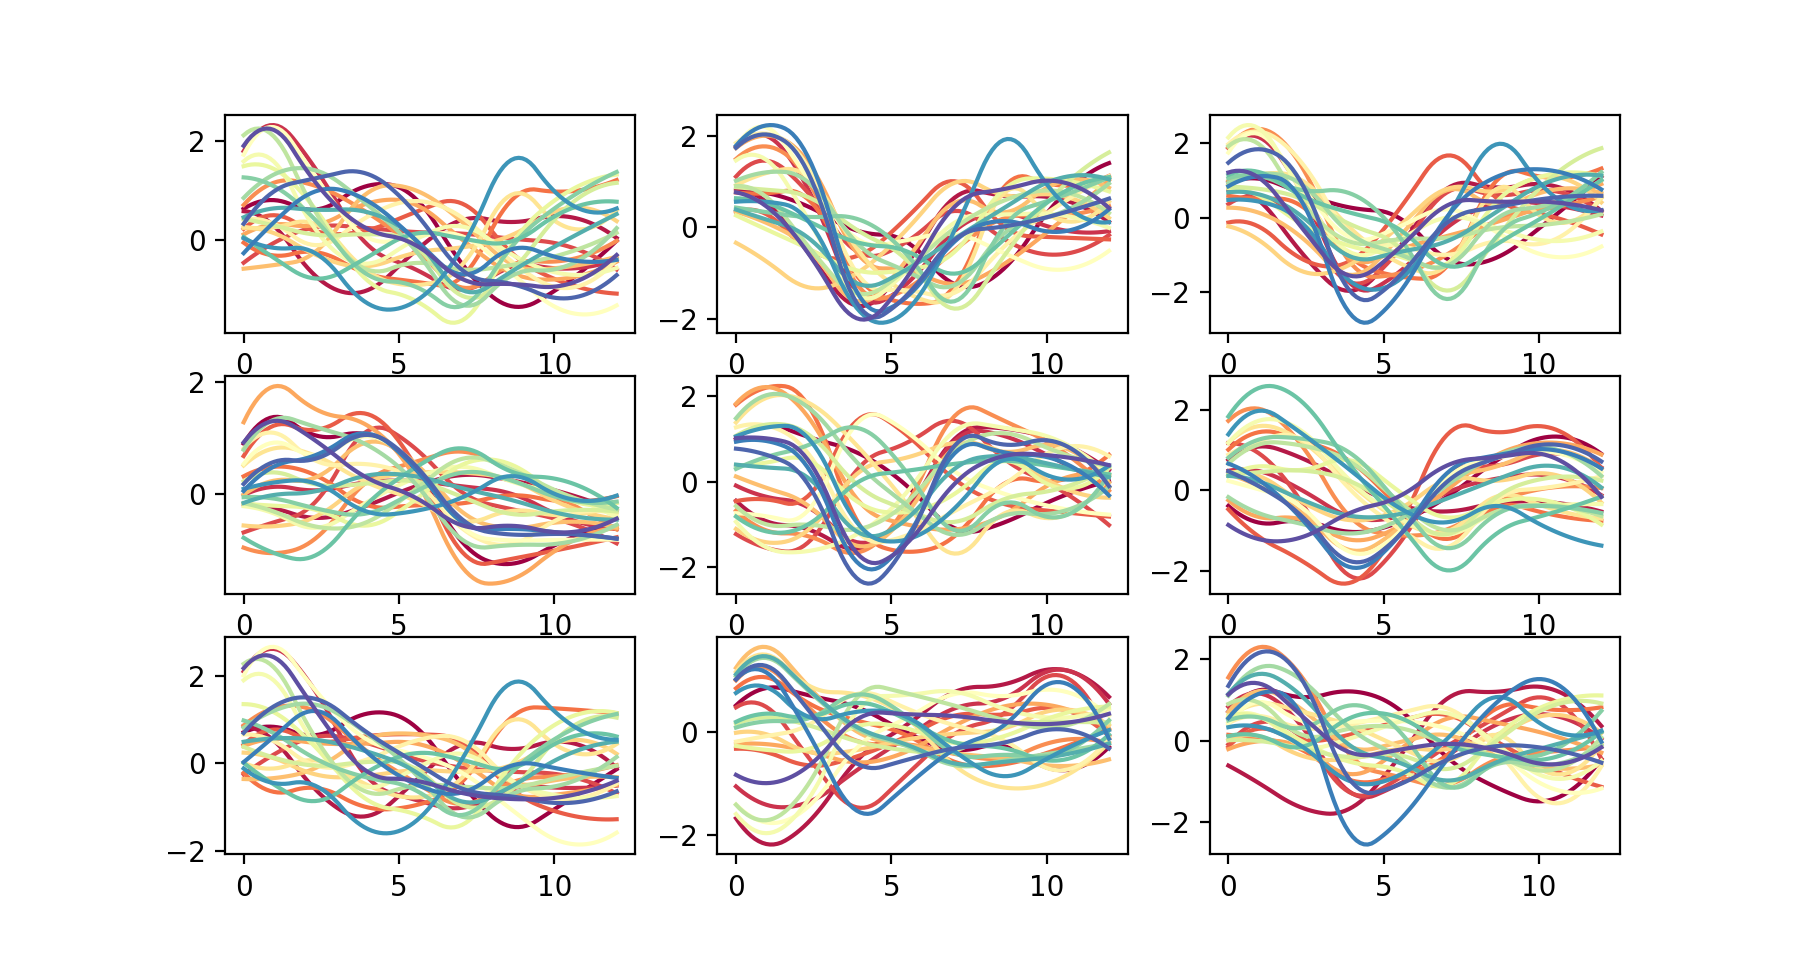

In [35]:
xs = np.linspace(0, 12, 100)
S = model.basis(xs).squeeze().T
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(model.n_classes):
    ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    for j in range(model.n_features):
        ax[j//3, j%3].plot(xs, ys[:,j], color=cmap[i])

### Dimension Reduction

Let $Y$ be a new datapoint that is not in the training set. Similar to training, we will construct the corresponding $S_Y$ and $C_Y$ matrix. Define $M_Y = \sigma^2I + (C^T\Psi C)\otimes (S\Sigma S^T)$ and $A_Y=(\xi C)^T\otimes(S\Lambda)$. Then, we choose $\hat{\alpha}_Y$ such that $$vec(\hat{\alpha}_Y)=(A_Y^TM_Y^{-1}A_Y)^{-\frac{1}{2}}A_Y^TM_Y^{-1}Y$$ Reshaping into an $r\times r$ matrix and taking the diagonal elements, we arrive at an $r$ dimensional representation of $Y$ that has unit covariance, since $var(vec(Y))=A_Y^TM_Y^{-1}A_Y$.

### Classification

Classification of a sample is done by computing the posterior probabilities of belonging to each class, and then choosing the class with the highest posterior. $$P(\text{class}=i|Y) = \frac{P(Y|\text{class}=i)P(\text{class}=i)}{\sum_{k=1}^KP(Y|\text{class}=k)P(\text{class}=k)}$$ Simplifying this tells us that it is enough to find the class $i$ such that the value of $||\hat{\alpha}_Y - (A_Y^TM_Y^{-1})A)^{\frac{1}{2}}vec(\alpha_i)||_F$ is minimized.

<IPython.core.display.Javascript object>


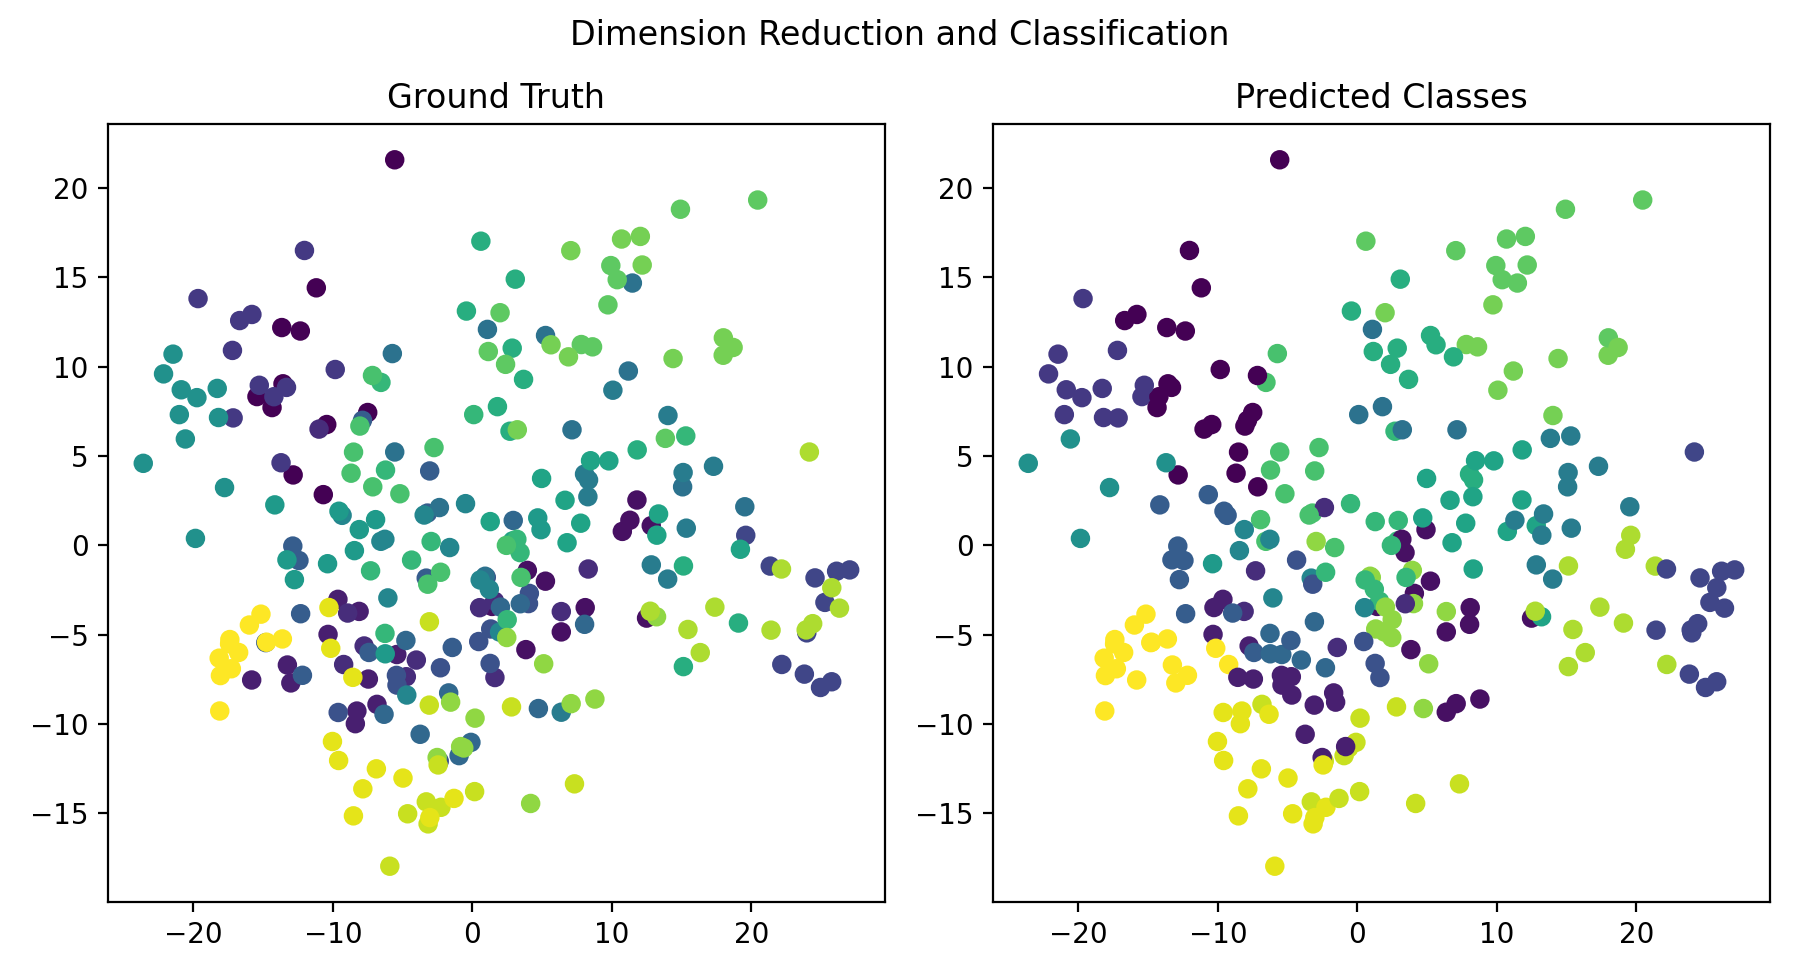

In [56]:
fig = plt.figure('Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121)
ax.scatter(pts[:,0], pts[:,1], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect(1)
ax = fig.add_subplot(122)
ax.scatter(pts[:,0], pts[:,1], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect(1)
fig.suptitle('Dimension Reduction and Classification')
fig.tight_layout()

In [24]:
X, y = pickle.load(open("testWordRecognition.pickle", 'rb'))
predY = model.predict(X)

In [25]:
print(classification_report(y, predY))

              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       0.86      1.00      0.92        12
           3       0.92      0.92      0.92        12
           4       1.00      0.92      0.96        12
           5       1.00      1.00      1.00        12
           6       0.79      0.92      0.85        12
           7       1.00      0.92      0.96        12
           8       0.86      1.00      0.92        12
           9       0.83      0.83      0.83        12
          10       0.92      1.00      0.96        12
          11       1.00      1.00      1.00        12
          12       0.91      0.83      0.87        12
          13       1.00      1.00      1.00        12
          14       0.85      0.92      0.88        12
          15       0.83      0.83      0.83        12
          16       0.70      0.58      0.64        12
          17       0.90      0.75      0.82        12
          18       0.91    

In [43]:
X[0][1::12,0]

array([ 0.        ,  1.00699301,  2.01398601,  3.02097902,  4.02797203,
        5.03496503,  6.04195804,  7.04895105,  8.05594406,  9.06293706,
       10.06993007, 11.07692308])

<IPython.core.display.Javascript object>


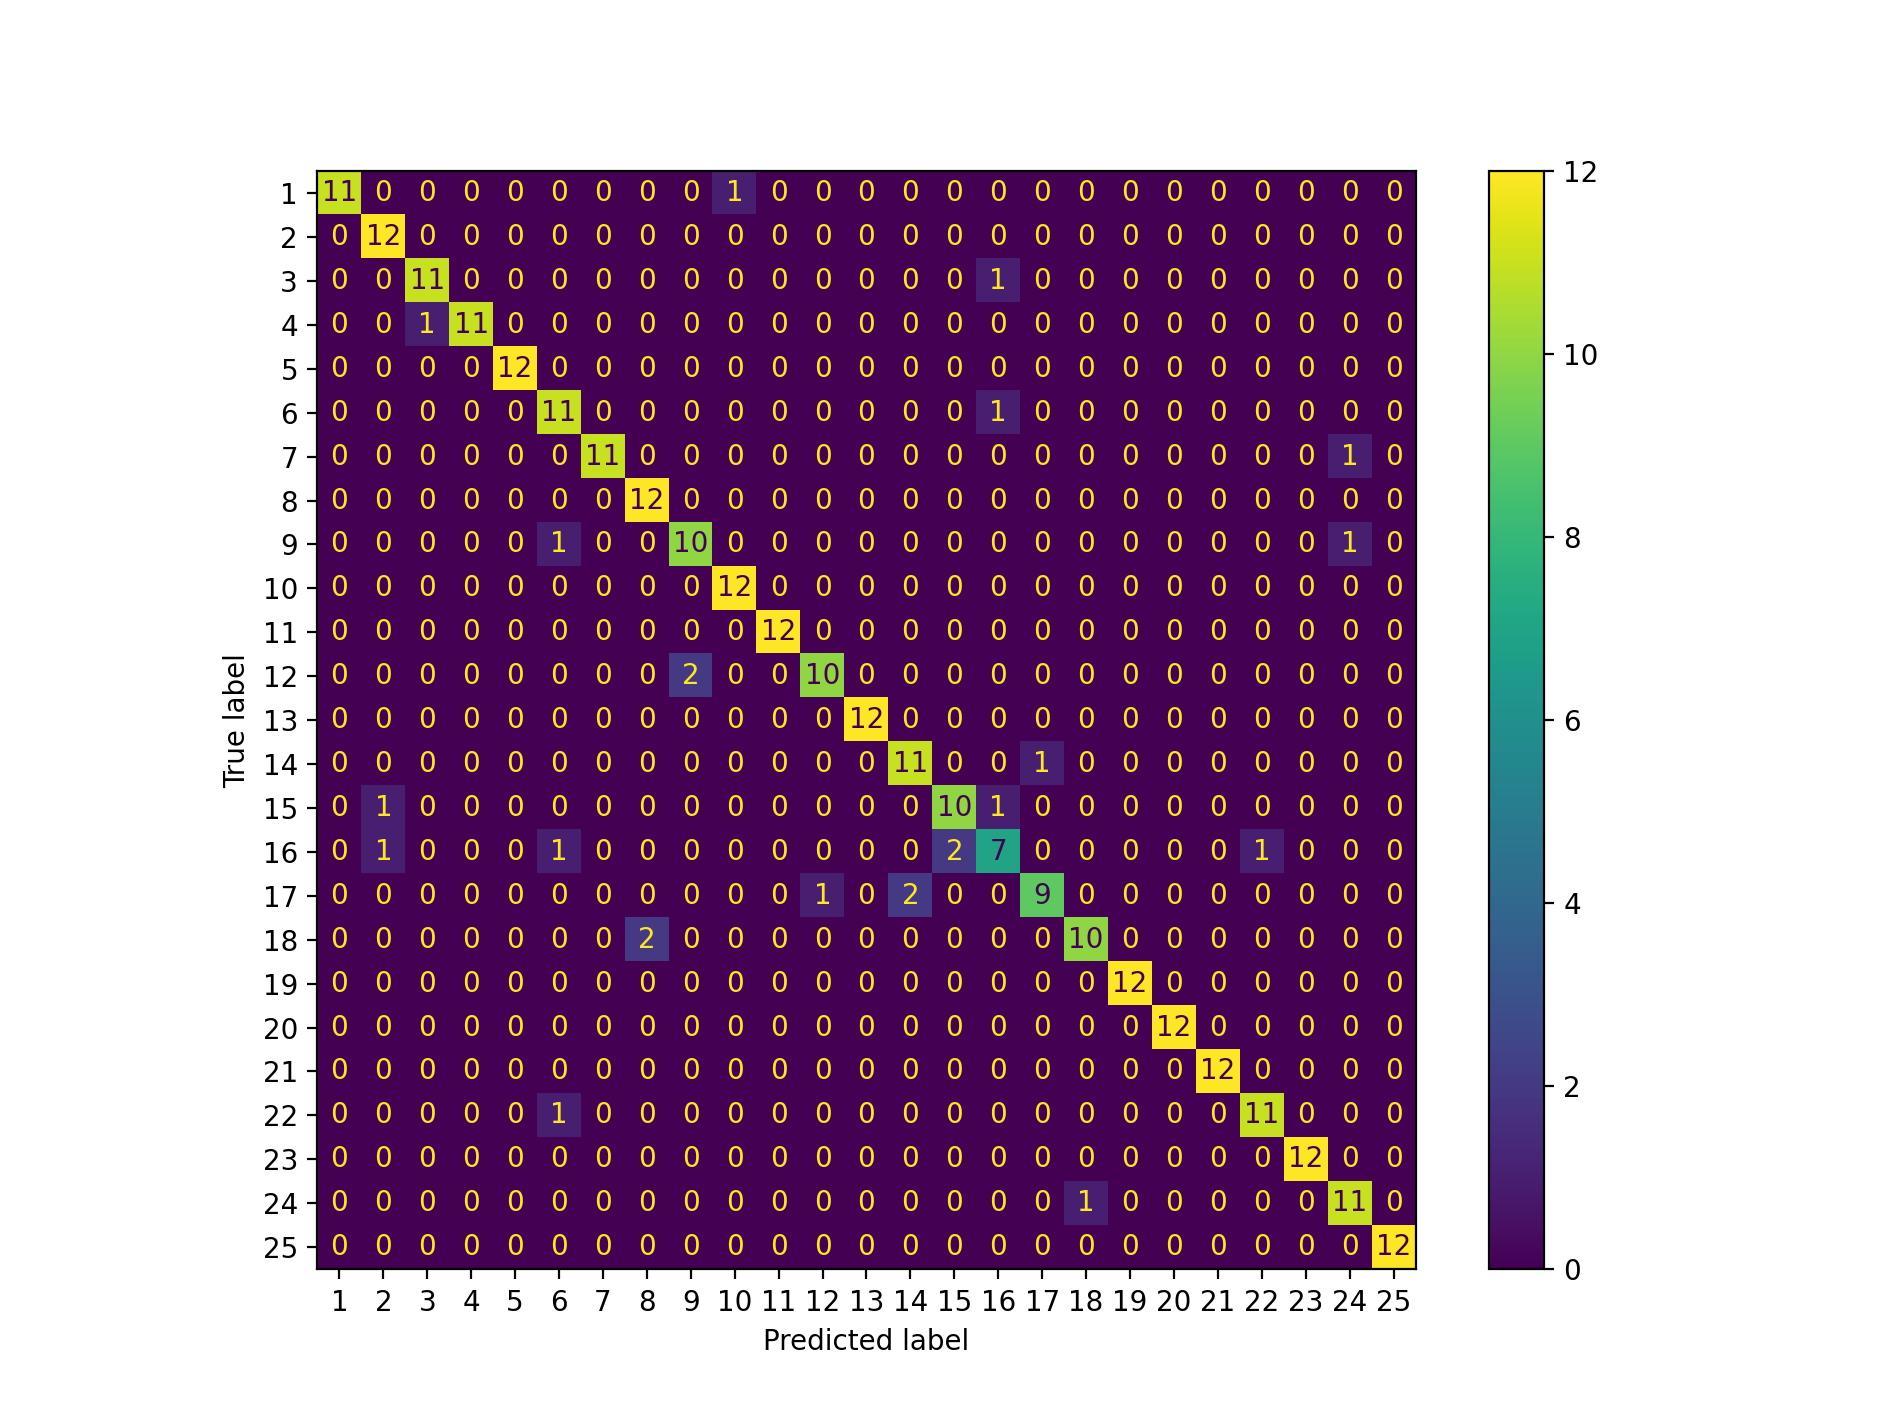

In [26]:
ConfusionMatrixDisplay.from_predictions(y, predY)

## r=3

### Fitting the data

In [10]:
model = MFLDA(r=3, n_iter=500, nBasis=6).fit(X, y)
pts = model.transform(X)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_109187/3429747893.py:115: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  SigmaNew += gamma[i] @ np.linalg.lstsq(Psi, gamma[i].T)[0]
/tmp/ipykernel_109187/3429747893.py:120: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  PsiNew += gamma[i].T @ np.linalg.lstsq(Sigma, gamma[i])[0]


[[3.79804147e+09 3.12573951e+09 2.07790168e+09 9.28612694e+08
  5.46361709e+08 2.62812450e+09]
 [3.12573951e+09 2.92356513e+09 2.55808487e+09 2.34866926e+09
  1.64922795e+09 3.26734266e+09]
 [2.07790168e+09 2.55808487e+09 3.62704871e+09 4.56666253e+09
  3.61977642e+09 4.61225584e+09]
 [9.28612694e+08 2.34866926e+09 4.56666252e+09 7.65739988e+09
  5.78817390e+09 5.90520459e+09]
 [5.46361709e+08 1.64922795e+09 3.61977642e+09 5.78817390e+09
  4.58587090e+09 4.62737885e+09]
 [2.62812450e+09 3.26734266e+09 4.61225584e+09 5.90520459e+09
  4.62737885e+09 6.07872565e+09]] [[1.07247020e-08 9.42882275e-09 1.06331476e-08 1.37028234e-08
  1.15864813e-08 1.11944267e-08 7.18394709e-09 1.06935549e-08
  1.06188270e-08]
 [9.42882275e-09 8.31414057e-09 9.35994375e-09 1.20525115e-08
  1.01434113e-08 9.84722919e-09 6.29461787e-09 9.37474970e-09
  9.31216528e-09]
 [1.06331476e-08 9.35994375e-09 1.06614184e-08 1.38137018e-08
  1.15314539e-08 1.13549072e-08 7.11981057e-09 1.06057656e-08
  1.05948526e-08]
 [1

[[ 5.10847991e-06 -1.00815156e-06 -1.12812390e-05 -2.33848485e-05
  -1.85262232e-05 -1.47785155e-05]
 [-1.00830782e-06  2.02120617e-07  2.22140014e-06  4.61548355e-06
   3.64928139e-06  2.91536618e-06]
 [-1.12811964e-05  2.22112740e-06  2.49216200e-05  5.16424408e-05
   4.09246399e-05  3.26386660e-05]
 [-2.33855172e-05  4.61524965e-06  5.16435465e-05  1.07055454e-04
   8.48096621e-05  6.76544606e-05]
 [-1.85264469e-05  3.64894996e-06  4.09251484e-05  8.48090032e-05
   6.72053694e-05  5.35997498e-05]
 [-1.47786282e-05  2.91505795e-06  3.26388806e-05  6.76532185e-05
   5.35993448e-05  4.27551092e-05]] [[3114.79817433 2736.49740731 3110.98939385 4028.9795143  3392.88361593
  3296.48526097 2096.43315355 3119.88012702 3112.01895107]
 [2736.49740759 2404.14230453 2733.15121392 3539.64892074 2980.80861089
  2896.11810008 1841.81560692 2740.96214321 2734.0557286 ]
 [3110.98939406 2733.15121384 3107.18527097 4024.0528716  3388.73479233
  3292.45431344 2093.86963169 3116.06513254 3108.21356924]


[[-4.88295889e-13  9.62839911e-14  1.07847120e-12  2.23531744e-12
   1.77103985e-12  1.41265930e-12]
 [ 9.62839892e-14 -1.89856338e-14 -2.12656939e-13 -4.40768162e-13
  -3.49220186e-13 -2.78553384e-13]
 [ 1.07847119e-12 -2.12656943e-13 -2.38195763e-12 -4.93701775e-12
  -3.91159439e-12 -3.12005977e-12]
 [ 2.23531744e-12 -4.40768169e-13 -4.93701774e-12 -1.02328203e-11
  -8.10745358e-12 -6.46686165e-12]
 [ 1.77103986e-12 -3.49220195e-13 -3.91159442e-12 -8.10745365e-12
  -6.42352770e-12 -5.12368828e-12]
 [ 1.41265930e-12 -2.78553391e-13 -3.12005978e-12 -6.46686169e-12
  -5.12368827e-12 -4.08687917e-12]] [[-3.06376044e+10 -2.69165578e+10 -3.06001086e+10 -3.96295829e+10
  -3.33728640e+10 -3.24246767e+10 -2.06208011e+10 -3.06875637e+10
  -3.06102414e+10]
 [-2.69165578e+10 -2.36474456e+10 -2.68836160e+10 -3.48164283e+10
  -2.93196103e+10 -2.84865838e+10 -1.81163311e+10 -2.69604493e+10
  -2.68925181e+10]
 [-3.06001086e+10 -2.68836160e+10 -3.05626587e+10 -3.95810823e+10
  -3.33320207e+10 -3.2384

[[  8689.63230677  -1713.39074515 -19192.35922457 -39779.46567139
  -31517.23938908 -25139.49224875]
 [ -1713.39073609    337.84028532   3784.28100263   7843.57329923
    6214.45695931   4956.91550672]
 [-19192.3592346    3784.28102463  42389.21049218  87858.92987583
   69610.56109678  55524.34777772]
 [-39779.46581417   7843.57336888  87858.93014524 182102.74487843
  144279.86165472 115083.76157442]
 [-31517.23946223   6214.45700662  69610.56122195 144279.86147172
  114312.82086082  91180.77373667]
 [-25139.49224322   4956.91553185  55524.34773648 115083.76113604
   91180.77350498  72729.66773738]] [[12.08831432 10.6200565  12.07341466 15.63603749 13.17103362 12.79683363
   8.1383041  12.11135526 12.0808242 ]
 [10.6200565   9.33013463 10.60696657 13.73686994 11.57126772 11.2425184
   7.14981817 10.64029887 10.61347614]
 [12.07341466 10.60696657 12.05853336 15.61676502 13.15479943 12.78106067
   8.12827309 12.0964272  12.06593377]
 [15.63603749 13.73686994 15.61676502 20.22495957 17.03

[[ 4.98634863e-20 -9.78023022e-21 -1.10205860e-19 -2.27969484e-19
  -1.84140046e-19 -1.40945126e-19]
 [-9.78033137e-21  1.91840200e-21  2.16158953e-20  4.47151554e-20
   3.61166653e-20  2.76446365e-20]
 [-1.10204796e-19  2.16154636e-20  2.43569980e-19  5.03838042e-19
   4.06978629e-19  3.11508346e-19]
 [-2.27978337e-19  4.47164310e-20  5.03862454e-19  1.04234284e-18
   8.41817486e-19  6.44401167e-19]
 [-1.84121105e-19  3.61125756e-20  4.06940708e-19  8.41698316e-19
   6.80182492e-19  5.20449437e-19]
 [-1.40949232e-19  2.76451579e-20  3.11520420e-19  6.44394928e-19
   5.20518147e-19  3.98426668e-19]] [[2.29212336e+19 2.01372917e+19 2.28930871e+19 2.96483699e+19
  2.49729592e+19 2.42634545e+19 1.54306523e+19 2.29637600e+19
  2.29058796e+19]
 [2.01372917e+19 1.76914787e+19 2.01125637e+19 2.60473709e+19
  2.19398211e+19 2.13164906e+19 1.35564931e+19 2.01746530e+19
  2.01238025e+19]
 [2.28930871e+19 2.01125637e+19 2.28649751e+19 2.96119627e+19
  2.49422932e+19 2.42336598e+19 1.54117040e+19 

[[ 1.86277365 -0.36535424 -4.11702793 -8.51586742 -6.88006673 -5.2657553 ]
 [-0.36535432  0.07186225  0.80734098  1.67016718  1.34933024  1.03269695]
 [-4.11702787  0.80734079  9.0994022  18.82149474 15.20611626 11.63823405]
 [-8.51586739  1.67016681 18.82149494 38.9312321  31.45298872 24.07300636]
 [-6.8800667   1.34932994 15.2061164  31.45298868 25.41125516 19.44885202]
 [-5.26575526  1.03269672 11.63823413 24.07300628 19.44885198 14.88548232]] [[0.00217398 0.00190994 0.00217132 0.00281203 0.00236859 0.00230129
  0.00146354 0.00217803 0.00217254]
 [0.00190994 0.00167797 0.0019076  0.00247049 0.00208091 0.00202179
  0.00128578 0.00191349 0.00190867]
 [0.00217132 0.0019076  0.00216865 0.00280858 0.00236568 0.00229847
  0.00146174 0.00217535 0.00216987]
 [0.00281203 0.00247049 0.00280858 0.00363734 0.00306375 0.00297671
  0.00189308 0.00281727 0.00281016]
 [0.00236859 0.00208091 0.00236568 0.00306375 0.00258061 0.00250729
  0.00159455 0.002373   0.00236701]
 [0.00230129 0.00202179 0.002

[[ -41.57455962    8.15354232   91.89385157  190.05393553  153.55406665
   117.52464465]
 [   8.15354203   -1.59906082  -18.02208824  -37.27310081  -30.11479984
   -23.04876194]
 [  91.8938523   -18.02208903 -203.11652363 -420.08354244 -339.40647457
  -259.76925406]
 [ 190.05393659  -37.27310234 -420.0835414  -868.81253675 -701.95704066
  -537.25214566]
 [ 153.55406927  -30.11480142 -339.40647765 -701.9570488  -567.14615765
  -434.07284661]
 [ 117.52464338  -23.04876252 -259.76924917 -537.25213685 -434.07283446
  -332.22340933]] [[-8.08624805e-05 -7.10412575e-05 -8.07632730e-05 -1.04595249e-04
  -8.81010589e-05 -8.55980131e-05 -5.44372499e-05 -8.10134559e-05
  -8.08092584e-05]
 [-7.10412578e-05 -6.24128799e-05 -7.09540995e-05 -9.18915432e-05
  -7.74006694e-05 -7.52016332e-05 -4.78255271e-05 -7.11738974e-05
  -7.09945009e-05]
 [-8.07632733e-05 -7.09540995e-05 -8.06641873e-05 -1.04466926e-04
  -8.79929719e-05 -8.54929970e-05 -5.43704635e-05 -8.09140646e-05
  -8.07101176e-05]
 [-1.0459525

[[ 4.91687203e-14 -9.64685378e-15 -1.08672131e-13 -2.24781084e-13
  -1.81603611e-13 -1.38991531e-13]
 [-9.64717492e-15  1.89270843e-15  2.13221594e-14  4.41033957e-14
   3.56317336e-14  2.72709798e-14]
 [-1.08671722e-13  2.13213679e-14  2.40184817e-13  4.96806451e-13
   4.01376479e-13  3.07196157e-13]
 [-2.24780637e-13  4.41018365e-14  4.96807331e-13  1.02761310e-12
   8.30222185e-13  6.35416066e-13]
 [-1.81603160e-13  3.56304565e-14  4.01376991e-13  8.30221777e-13
   6.70747126e-13  5.13360771e-13]
 [-1.38991217e-13  2.72700082e-14  3.07196620e-13  6.35415898e-13
   5.13360888e-13  3.92904167e-13]] [[9.79259598e+10 8.60307242e+10 9.78041553e+10 1.26763788e+11
  1.06773654e+11 1.03740076e+11 6.59737079e+10 9.81964334e+10
  9.79488739e+10]
 [8.60307243e+10 7.55804235e+10 8.59237155e+10 1.11365572e+11
  9.38036739e+10 9.11385897e+10 5.79597676e+10 8.62683429e+10
  8.60508549e+10]
 [9.78041553e+10 8.59237155e+10 9.76825023e+10 1.26606114e+11
  1.06640845e+11 1.03611040e+11 6.58916470e+10 

[[  22.9978889    -4.51256752  -50.82925366 -105.13781247  -84.94189255
   -65.01100255]
 [  -4.51256751    0.88543415    9.97354856   20.62978097   16.66702079
    12.75622842]
 [ -50.82925363    9.97354859  112.3413069   232.37248196  187.73604654
   143.68539997]
 [-105.13781246   20.62978106  232.37248212  480.65103618  388.32282512
   297.20613995]
 [ -84.94189229   16.66702079  187.73604612  388.32282395  313.7298379
   240.11589417]
 [ -65.0110027    12.75622851  143.6854004   297.20614063  240.11589544
   183.77463445]] [[8.45899078e-05 7.43146210e-05 8.44846862e-05 1.09500443e-04
  9.22326683e-05 8.96122185e-05 5.69890649e-05 8.48235386e-05
  8.46096932e-05]
 [7.43146210e-05 6.52874915e-05 7.42221808e-05 9.61992293e-05
  8.10290017e-05 7.87268626e-05 5.00665016e-05 7.45198723e-05
  7.43320030e-05]
 [8.44846862e-05 7.42221808e-05 8.43795955e-05 1.09364235e-04
  9.21179398e-05 8.95007496e-05 5.69181761e-05 8.47180264e-05
  8.45044470e-05]
 [1.09500443e-04 9.61992293e-05 1.093642

[[ 0.26660406 -0.05230657 -0.58924554 -1.21881321 -0.98470205 -0.75363616]
 [-0.05230657  0.01026232  0.11560743  0.23912589  0.19319429  0.14786016]
 [-0.58924554  0.11560743  1.30234443  2.6938084   2.17637833  1.66567889]
 [-1.21881321  0.23912589  2.6938084   5.57195437  4.5016864   3.44534033]
 [-0.98470205  0.19319429  2.17637833  4.5016864   3.63699689  2.78355506]
 [-0.75363616  0.14786016  1.66567889  3.44534033  2.78355506  2.13037821]] [[0.00473216 0.00415734 0.00472628 0.00612572 0.00515972 0.00501313
  0.00318812 0.00474525 0.00473328]
 [0.00415734 0.00365235 0.00415218 0.00538163 0.00453297 0.00440418
  0.00280085 0.00416884 0.00415833]
 [0.00472628 0.00415218 0.00472041 0.00611811 0.00515331 0.0050069
  0.00318416 0.00473935 0.00472741]
 [0.00612572 0.00538163 0.00611811 0.00792968 0.0066792  0.00648944
  0.00412698 0.00614267 0.00612718]
 [0.00515972 0.00453297 0.00515331 0.0066792  0.00562592 0.00546608
  0.00347617 0.005174   0.00516095]
 [0.00501313 0.00440418 0.0050

[[ 0.56618454 -0.11108469 -1.25136787 -2.58837211 -2.09119318 -1.60048326]
 [-0.11108469  0.02179468  0.24551679  0.50783534  0.41028946  0.31401279]
 [-1.25136787  0.24551679  2.76574407  5.72075966  4.6219064   3.53735076]
 [-2.58837211  0.50783534  5.72075966 11.83301502  9.56010932  7.31677734]
 [-2.09119318  0.41028946  4.6219064   9.56010932  7.72378724  5.91135827]
 [-1.60048326  0.31401279  3.53735076  7.31677734  5.91135827  4.5242257 ]] [[0.00110656 0.00097215 0.00110519 0.00143243 0.00120654 0.00117226
  0.0007455  0.00110962 0.00110682]
 [0.00097215 0.00085406 0.00097094 0.00125843 0.00105998 0.00102987
  0.00065495 0.00097483 0.00097238]
 [0.00110519 0.00097094 0.00110381 0.00143065 0.00120504 0.0011708
  0.00074458 0.00110824 0.00110545]
 [0.00143243 0.00125843 0.00143065 0.00185426 0.00156185 0.00151748
  0.00096505 0.00143639 0.00143277]
 [0.00120654 0.00105998 0.00120504 0.00156185 0.00131556 0.00127818
  0.00081286 0.00120988 0.00120683]
 [0.00117226 0.00102987 0.0011

[[ 0.00604695 -0.00118598 -0.01336304 -0.0276406  -0.02233159 -0.01709061]
 [-0.00118598  0.00023279  0.00262066  0.00542093  0.00437959  0.003352  ]
 [-0.01336304  0.00262065  0.02953109  0.06108273  0.04935072  0.03776813]
 [-0.02764059  0.00542092  0.06108273  0.12634538  0.10207807  0.07812111]
 [-0.02233158  0.00437959  0.04935072  0.10207806  0.08247244  0.0631159 ]
 [-0.01709061  0.00335199  0.03776814  0.07812112  0.06311591  0.04830373]] [[0.03641676 0.03199313 0.03637148 0.04713811 0.03970626 0.03857815
  0.0245338  0.03651657 0.03642466]
 [0.03199313 0.02810685 0.03195335 0.04141214 0.03488305 0.03389198
  0.02155362 0.03208082 0.03200008]
 [0.03637148 0.03195335 0.03632626 0.04707951 0.03965689 0.03853019
  0.0245033  0.03647117 0.03637938]
 [0.04713811 0.04141214 0.04707951 0.06101592 0.05139607 0.04993584
  0.03175673 0.04726732 0.04714835]
 [0.03970626 0.03488305 0.03965689 0.05139607 0.04329291 0.0420629
  0.02674992 0.0398151  0.03971488]
 [0.03857815 0.03389198 0.0385

[[ 1.81571215e-08 -3.56043088e-09 -4.01262227e-08 -8.29972381e-08
  -6.70560581e-08 -5.13184995e-08]
 [-3.56043085e-09  6.98165068e-10  7.86835301e-09  1.62749326e-08
   1.31490258e-08  1.00630471e-08]
 [-4.01262226e-08  7.86835304e-09  8.86767071e-08  1.83419253e-07
   1.48190137e-07  1.13411013e-07]
 [-8.29972378e-08  1.62749326e-08  1.83419253e-07  3.79385109e-07
   3.06517066e-07  2.34579788e-07]
 [-6.70560578e-08  1.31490258e-08  1.48190137e-07  3.06517066e-07
   2.47644701e-07  1.89524330e-07]
 [-5.13184994e-08  1.00630472e-08  1.13411013e-07  2.34579789e-07
   1.89524330e-07  1.45044378e-07]] [[-0.92243325 -0.81038313 -0.92151916 -1.20524974 -1.01487017 -0.98603723
  -0.62718065 -0.93350123 -0.93119874]
 [-0.81038323 -0.71194409 -0.80958017 -1.05884538 -0.89159164 -0.86626111
  -0.55099562 -0.82010677 -0.81808396]
 [-0.92150158 -0.80956463 -0.92058718 -1.20397116 -1.01379535 -0.98499294
  -0.62651528 -0.93251093 -0.93021061]
 [-1.20438103 -1.05808209 -1.20312741 -1.57058968 -1.3

  0%|          | 0/275 [00:00<?, ?it/s]

### Plot the estimated class functionals

In [ ]:
xs = np.linspace(model.splineDomain[0], model.splineDomain[1], 100)
S = np.array(model.basis(xs).squeeze().T)
fig = plt.figure('Estimated Functionals', constrained_layout=True)
fig.set_figwidth(9)
fig.set_figheight(7)
subFigs = fig.subfigures(nrows=2)
subFigs[0].suptitle('True Functionals')
subFigs[1].suptitle('Estimated Functionals')
ax = [subFigs[1].add_subplot(121), subFigs[1].add_subplot(122)]
for i in range(model.n_classes):
    ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    for j in range(model.n_features):
        className = 'Class ' + str(i+1)
        ax[j].plot(xs*11, ys[:,j], color=cmap[i], label=className)
for i in range(3):
    for j in range(1, X[i*100].shape[1]):
        featIdx = X[i*100][0, j].astype('int')
        target = 'Class ' + str(i+1)
        ax[featIdx].plot(X[i*100][1:,0]*11, X[i*100][1:, j], '.', markersize=15, color=cmap[i])
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
ax = [subFigs[0].add_subplot(121), subFigs[0].add_subplot(122)]
ax[0].plot(xs*11, normalize(np.exp(xs)), color=cmap[0], label='Class 1')
ax[1].plot(xs*11, normalize(1/(xs + 0.1)), color=cmap[0], label='Class 1')
ax[0].plot(xs*11, normalize(-xs), color=cmap[1], label='Class 2')
ax[1].plot(xs*11, normalize(np.sin(xs)), color=cmap[1], label='Class 2')
ax[0].plot(xs*11, normalize(np.log(xs + np.exp(-10))), color=cmap[2], label='Class 3')
ax[1].plot(xs*11, normalize(xs**2), color=cmap[2], label='Class 3')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
# fig.tight_layout()
plt.savefig('functionals.svg')

### Cluster plots

In [22]:
model.thetaSigma_ @ np.diag(model.DSigma_) @ model.thetaSigma_.T

array([[15991796.98764231,  3430342.2456184 ,  3789882.57908618,
         2385037.84929842, -5633621.40451026],
       [ 3430342.2456184 , 33327679.83372564, 15963742.51378986,
        -3312116.04272937, 11289042.84499588],
       [ 3789882.57908618, 15963742.51378985, 43731532.64235208,
         2375066.83822372,  5876330.17668787],
       [ 2385037.84929842, -3312116.04272937,  2375066.83822371,
        14711647.69043412,  7147593.51402139],
       [-5633621.40451026, 11289042.84499588,  5876330.17668787,
         7147593.51402139, 13234395.02619244]])

In [7]:
pts

array([[ 4.50448684e+00, -6.70861984e+00,  5.69536535e+00],
       [ 2.14219457e+00, -2.46242723e+00,  3.91534326e+00],
       [ 4.31225304e+00, -9.40906643e+00,  9.60701369e+00],
       [ 2.36268936e+00, -8.05550210e+00,  9.18101053e+00],
       [ 3.07380173e+00,  1.57435245e+00,  8.35086316e+00],
       [ 4.43646680e+00, -7.14653749e+00,  6.15618030e+00],
       [ 4.92865336e+00, -8.53214193e+00,  5.78771363e+00],
       [ 6.23693612e+00, -1.23520374e+01,  1.31431974e+01],
       [ 3.78499645e+00, -5.91620943e+00,  2.47520127e+00],
       [ 3.99782948e+00, -1.18452504e+01,  1.02798651e+01],
       [ 5.29795484e+00, -1.13685758e+01,  1.11010315e+01],
       [-2.17332855e+00,  1.64983779e+01, -1.12051735e+01],
       [-2.76385114e+00,  1.67566015e+01, -4.53486581e+00],
       [-2.61704062e+00,  8.87442255e+00, -9.54231397e+00],
       [-3.42282033e+00,  1.16486083e+01, -6.49375704e+00],
       [-2.76285647e+00,  6.70194497e+00, -6.89937177e+00],
       [-3.41649186e+00,  1.73184560e+01

<IPython.core.display.Javascript object>


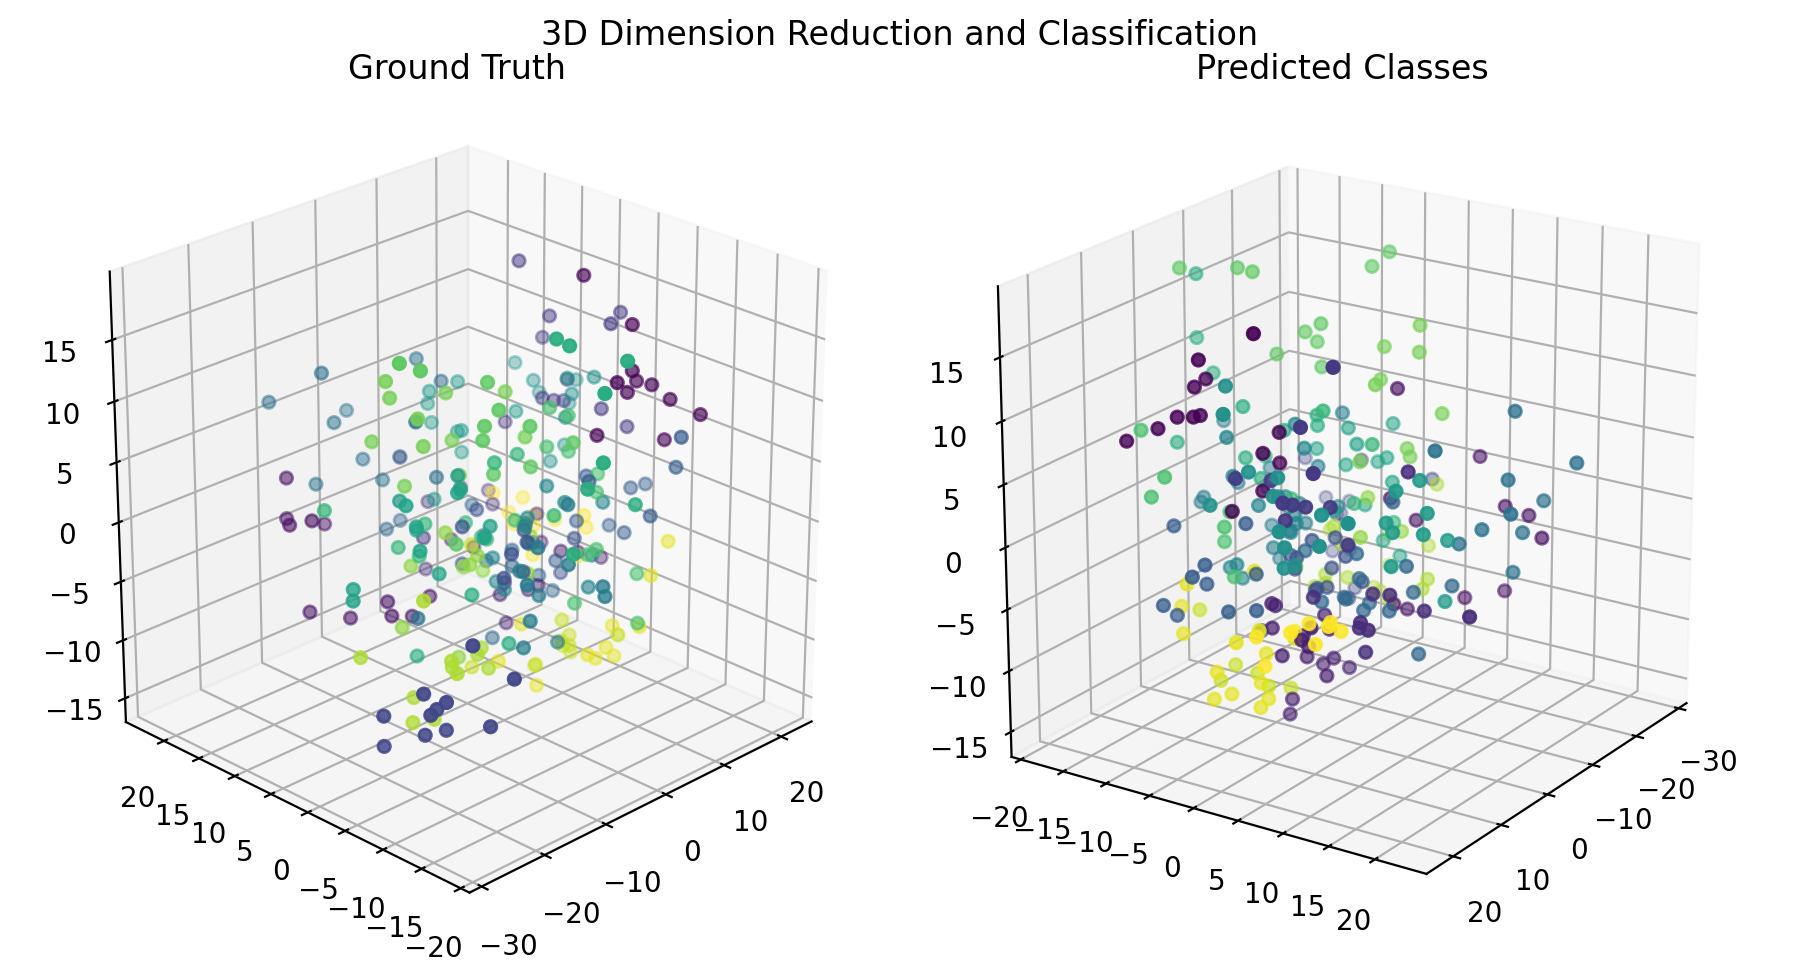

In [11]:
fig = plt.figure('3D Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect((1, 1, 1))
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect((1, 1, 1))
fig.suptitle('3D Dimension Reduction and Classification')
fig.tight_layout()